In [1]:
import os

In [2]:
os.chdir('..')

In [3]:
os.listdir()

['demo', '__init__.py', '__pycache__', 'utils.py', 'data']

In [4]:
import utils

In [5]:
import pickle

In [6]:
with open('data/rank_to_factors.p', 'rb') as f:
    rank_to_factors = pickle.load(f)

In [7]:
rank_to_factors[9][0].shape # comment step (ordered)

(9, 9)

In [8]:
rank_to_factors[9][1].shape # threads (unordered)

(10000, 9)

In [9]:
rank_to_factors[9][2].shape # hypergraph_feats (unordered)

(164, 9)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Comment step", "Threads", "Features"] if d==3 else ["Time", "Features"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()

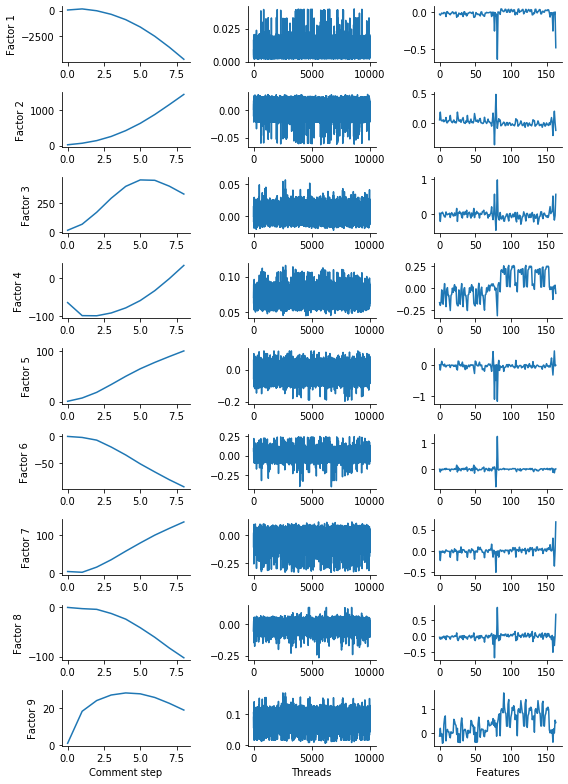

In [12]:
plot_factors(rank_to_factors[9])

## Interpreting the factors

In [21]:
time_factor = rank_to_factors[9][0] # (9, 9)
thread_factor = rank_to_factors[9][1] # (10000, 9)
feature_factor = rank_to_factors[9][2] # (164, 9)

In [24]:
feature_factor.shape

(164, 9)

In [73]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

In [85]:
with open('data/hg_features.p', 'rb') as f:
    hg_features = pickle.load(f)

In [99]:
with open('data/subreddits.p', 'rb') as f:
    subreddits = pickle.load(f)

In [136]:
def get_anomalous_points(factor_full, idx):
    factor = factor_full[:, idx]
    reshaped = factor.reshape((factor.shape[0], 1))
    scaled = scaler.fit_transform(reshaped)
    pos_pts = np.argwhere(scaled.reshape(factor.shape[0]) > 1.5).flatten()
    neg_pts = np.argwhere(scaled.reshape(factor.shape[0]) < -1.5).flatten()
    return pos_pts, neg_pts

In [137]:
pos_pts, neg_pts = get_anomalous_points(feature_factor, 0)

In [138]:
for pt in neg_pts:
    print(hg_features[pt])

count[dyadic interaction motif]
count[outgoing triads]
count[dyadic interaction motif over mid-thread]
count[outgoing triads over mid-thread]


In [139]:
from collections import defaultdict, Counter

In [140]:
idx_to_distinctive_threads = defaultdict(dict)
idx_to_distinctive_features = defaultdict(dict)

In [141]:
for idx in range(9):
    pos_thread_pts, neg_thread_pts = get_anomalous_points(thread_factor, idx)
    idx_to_distinctive_threads[idx]['pos_threads'] = Counter([subreddits[i] for i in pos_thread_pts])
    idx_to_distinctive_threads[idx]['neg_threads'] = Counter([subreddits[i] for i in neg_thread_pts])
    
    pos_features, neg_features = get_anomalous_points(feature_factor, idx)
    idx_to_distinctive_features[idx]['pos_features'] = [hg_features[i] for i in pos_features]
    idx_to_distinctive_features[idx]['neg_features'] = [hg_features[i] for i in neg_features]

In [142]:
for idx in range(9):
    print("### FACTOR {} ###".format(idx+1))
    
    pos_subreddits = sorted(list(idx_to_distinctive_threads[idx]['pos_threads'].items()), key=lambda x: x[1], reverse=True)
    neg_subreddits = sorted(list(idx_to_distinctive_threads[idx]['neg_threads'].items()), key=lambda x: x[1], reverse=True)

    print()
    print("Positive subreddits: {}".format([k for k, v in pos_subreddits[:10]]))
    print()
    print("Negative subreddits: {}".format([k for k, v in neg_subreddits[:10]]))
    print()
    print("Positive features: {}".format(idx_to_distinctive_features[idx]['pos_features'][:10]))
    print()
    print("Negative features: {}".format(idx_to_distinctive_features[idx]['neg_features'][:10]))
    
    print("#########################################\n\n")

### FACTOR 1 ###

Positive subreddits: ['pokemontrades', 'gonewild', 'techsupport', 'POLITIC', 'science', 'buildapc', 'teenagers', 'DebateReligion', 'Economics', 'electronic_cigarette']

Negative subreddits: []

Positive features: []

Negative features: ['count[dyadic interaction motif]', 'count[outgoing triads]', 'count[dyadic interaction motif over mid-thread]', 'count[outgoing triads over mid-thread]']
#########################################


### FACTOR 2 ###

Positive subreddits: ['CFB', 'AskMen', 'fantasyfootball', 'books', 'singapore', 'politics', 'tifu', 'videos', 'soccer', 'aww']

Negative subreddits: ['pokemontrades', 'gonewild', 'techsupport', 'POLITIC', 'buildapc', 'science', 'teenagers', 'DebateReligion', 'Economics', 'electronic_cigarette']

Positive features: ['max[indegree over c->c responses]', 'mean-nonzero[indegree over c->c responses]', 'max[indegree over C->c responses]', 'mean-nonzero[indegree over C->c responses]', 'max[indegree over C->C responses]', 'count[ex